In [1]:
#================================
# 0. Imports and global settings
#================================
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor

import matplotlib.pyplot as plt

np.random.seed(42)
RANDOM_STATE = 42

# Display options
pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", "{:,.4f}".format)


In [2]:
# ================================
# 1. Load Kaggle House Prices data
# ================================


# Load the datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

train_df.head()


Train shape: (1460, 81)
Test shape : (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,"2,003.0000",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.0000",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.0000",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.0000",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.0000",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


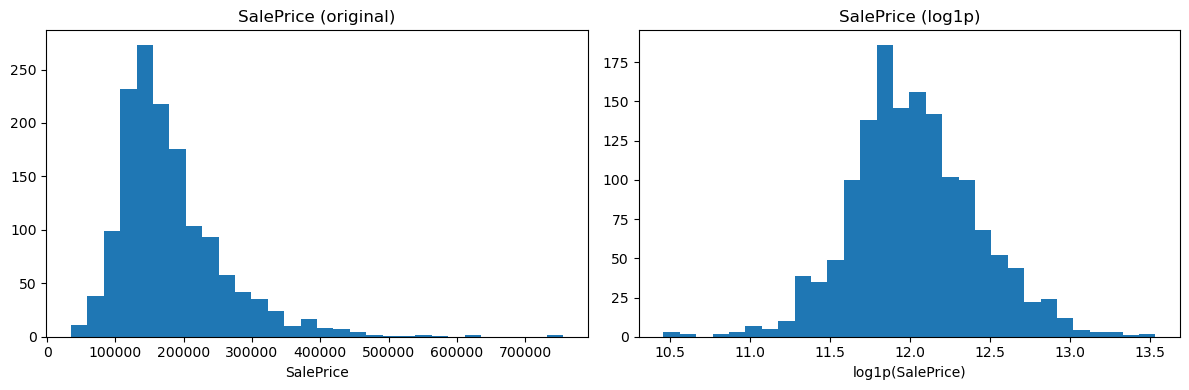

In [3]:
# ================================
# 2. Basic target exploration
# ================================
target = "SalePrice"
y = train_df[target]
X_full = train_df.drop(columns=[target])

# Log-transform the target to reduce skewness
y_log = np.log1p(y)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y, bins=30)
axes[0].set_title("SalePrice (original)")
axes[0].set_xlabel("SalePrice")

axes[1].hist(y_log, bins=30)
axes[1].set_title("SalePrice (log1p)")
axes[1].set_xlabel("log1p(SalePrice)")

plt.tight_layout()
plt.show()


In [4]:
# ================================
# 3. Data types and missing values
# ================================

# Identify numeric and categorical columns from raw dtypes
numeric_features_raw = X_full.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features_raw = X_full.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features (raw):", len(numeric_features_raw))
print("Categorical features (raw):", len(categorical_features_raw))

# Missing value percentages
missing_pct = train_df.isnull().mean().sort_values(ascending=False)
missing_pct[missing_pct > 0].head(25)


Numeric features (raw): 37
Categorical features (raw): 43


PoolQC         0.9952
MiscFeature    0.9630
Alley          0.9377
Fence          0.8075
MasVnrType     0.5973
FireplaceQu    0.4726
LotFrontage    0.1774
GarageYrBlt    0.0555
GarageCond     0.0555
GarageType     0.0555
GarageFinish   0.0555
GarageQual     0.0555
BsmtFinType2   0.0260
BsmtExposure   0.0260
BsmtQual       0.0253
BsmtCond       0.0253
BsmtFinType1   0.0253
MasVnrArea     0.0055
Electrical     0.0007
dtype: float64

In [5]:
# ================================
# 4. Domain-aware preprocessing
# ================================

# Columns where NA means "no such feature" (based on data_description.txt)
na_as_none_cols = [
    "Alley",
    "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
    "FireplaceQu",
    "GarageType", "GarageFinish", "GarageQual", "GarageCond",
    "PoolQC",
    "Fence",
    "MiscFeature"
]

# Columns that are numeric but better treated as categorical
numeric_to_categorical = ["MSSubClass"]

def basic_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # 1) Cast certain numeric codes to strings
    for col in numeric_to_categorical:
        if col in df.columns:
            df[col] = df[col].astype(str)

    # 2) Fill NA-as-none cols with explicit "None" category
    for col in na_as_none_cols:
        if col in df.columns:
            df[col] = df[col].fillna("None")

    return df

X_full_clean = basic_cleaning(X_full)
test_df_clean = basic_cleaning(test_df)

# Re-detect feature types after cleaning
numeric_features = X_full_clean.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_full_clean.select_dtypes(include=["object"]).columns.tolist()

len(numeric_features), len(categorical_features)


(36, 44)

In [6]:
# ================================
# 5. Preprocessing pipelines
# ================================

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
    # No scaler needed for tree-based models like XGBoost
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [7]:
# ================================
# 6. Train/validation split
# ================================
X_train, X_val, y_train, y_val = train_test_split(
    X_full_clean,
    y_log,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True,
)

X_train.shape, X_val.shape


((1168, 80), (292, 80))

In [8]:
# ================================
# 7. Baseline XGBoost model
# ================================

xgb_baseline = XGBRegressor(
    objective="reg:squarederror",
    random_state=RANDOM_STATE,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist"  # faster on CPUs
)

baseline_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", xgb_baseline),
])

baseline_model.fit(X_train, y_train)

y_val_pred_log = baseline_model.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)
y_val_true = np.expm1(y_val)

def regression_metrics(y_true, y_pred, n_features=None):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    if n_features is not None:
        n = len(y_true)
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    else:
        adj_r2 = None
    return mse, rmse, mae, r2, adj_r2

# To compute adjusted R², get transformed feature dimension
X_val_transformed = baseline_model.named_steps["preprocess"].transform(X_val)
n_features_transformed = X_val_transformed.shape[1]

mse, rmse, mae, r2, adj_r2 = regression_metrics(y_val_true, y_val_pred, n_features_transformed)

print(f"Baseline XGBoost metrics on validation (SalePrice scale):")
print(f"MSE  : {mse:,.4f}")
print(f"RMSE : {rmse:,.4f}")
print(f"MAE  : {mae:,.4f}")
print(f"R²   : {r2:,.4f}")
print(f"Adj R²: {adj_r2:,.4f}")


Baseline XGBoost metrics on validation (SalePrice scale):
MSE  : 632,490,725.1945
RMSE : 25,149.3683
MAE  : 15,461.3470
R²   : 0.9175
Adj R²: 2.0433


In [9]:
# ================================
# 8. Cross-validation (baseline model)
# ================================
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

neg_rmse_scores = cross_val_score(
    baseline_model, X_full_clean, y_log,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1
)

rmse_scores = -neg_rmse_scores
print("CV RMSE scores (log-space):", rmse_scores)
print("Mean CV RMSE (log-space):", rmse_scores.mean())


CV RMSE scores (log-space): [0.13314394 0.11574703 0.1631611  0.12758698 0.10715097]
Mean CV RMSE (log-space): 0.1293580042184333


In [10]:
# ================================
# 9. Hyperparameter tuning (XGBoost + GridSearchCV)
# ================================

xgb_for_tuning = XGBRegressor(
    objective="reg:squarederror",
    random_state=RANDOM_STATE,
    tree_method="hist",
    n_estimators=500,
)

xgb_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", xgb_for_tuning),
])

param_grid = {
    "model__max_depth": [3, 4, 5, 6],
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__min_child_weight": [1, 5, 10, 50],
    "model__subsample": [0.7, 0.8, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 1.0],
    "model__gamma": [0, 0.001, 0.01],
}

grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV score (neg RMSE, log-space):", grid_search.best_score_)


Fitting 3 folds for each of 1296 candidates, totalling 3888 fits
[CV] END model__colsample_bytree=0.7, model__gamma=0, model__learning_rate=0.03, model__max_depth=3, model__min_child_weight=1, model__subsample=0.7; total time=   0.2s
[CV] END model__colsample_bytree=0.7, model__gamma=0, model__learning_rate=0.03, model__max_depth=3, model__min_child_weight=1, model__subsample=0.7; total time=   0.2s
[CV] END model__colsample_bytree=0.7, model__gamma=0, model__learning_rate=0.03, model__max_depth=3, model__min_child_weight=1, model__subsample=0.8; total time=   0.2s
[CV] END model__colsample_bytree=0.7, model__gamma=0, model__learning_rate=0.03, model__max_depth=3, model__min_child_weight=1, model__subsample=0.8; total time=   0.3s
[CV] END model__colsample_bytree=0.7, model__gamma=0, model__learning_rate=0.03, model__max_depth=3, model__min_child_weight=1, model__subsample=0.8; total time=   0.3s
[CV] END model__colsample_bytree=0.7, model__gamma=0, model__learning_rate=0.03, model__ma

In [11]:
# ================================
# 10. Evaluation of tuned model
# ================================
best_model = grid_search.best_estimator_

y_val_pred_log_best = best_model.predict(X_val)
y_val_pred_best = np.expm1(y_val_pred_log_best)

mse_b, rmse_b, mae_b, r2_b, adj_r2_b = regression_metrics(
    y_val_true, y_val_pred_best,
    best_model.named_steps["preprocess"].transform(X_val).shape[1]
)

print("Tuned XGBoost metrics on validation (SalePrice scale):")
print(f"MSE  : {mse_b:,.4f}")
print(f"RMSE : {rmse_b:,.4f}")
print(f"MAE  : {mae_b:,.4f}")
print(f"R²   : {r2_b:,.4f}")
print(f"Adj R²: {adj_r2_b:,.4f}")


Tuned XGBoost metrics on validation (SalePrice scale):
MSE  : 647,726,550.4016
RMSE : 25,450.4725
MAE  : 15,303.7658
R²   : 0.9156
Adj R²: 2.0684


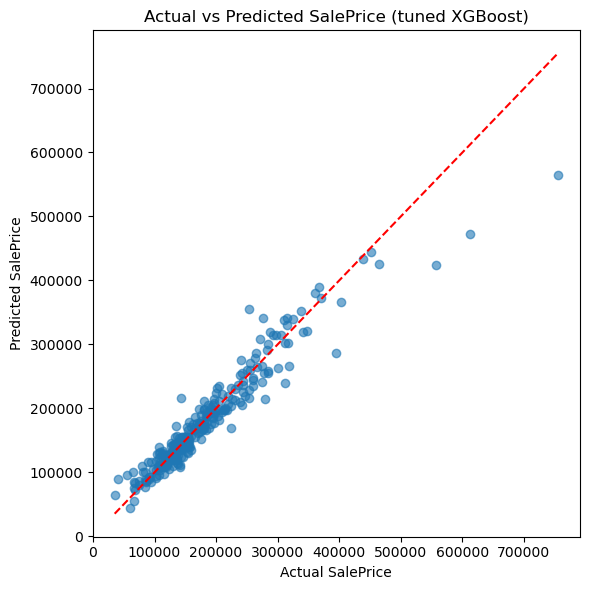

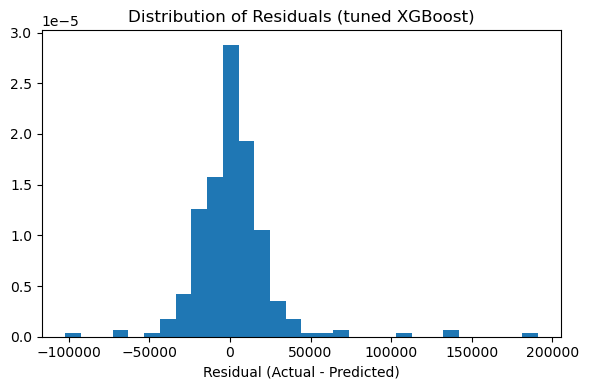

In [12]:
# ================================
# 11. Residual analysis
# ================================
residuals = y_val_true - y_val_pred_best

# Scatter: actual vs predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_val_true, y_val_pred_best, alpha=0.6)
max_val = max(y_val_true.max(), y_val_pred_best.max())
min_val = min(y_val_true.min(), y_val_pred_best.min())
plt.plot([min_val, max_val], [min_val, max_val], "r--")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice (tuned XGBoost)")
plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, density=True)
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Distribution of Residuals (tuned XGBoost)")
plt.tight_layout()
plt.show()


In [13]:
# ================================
# 12. Feature importance (XGBoost)
# ================================
# Extract underlying trained XGBRegressor
xgb_fitted = best_model.named_steps["model"]

# Get feature names from ColumnTransformer
ohe = best_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
num_feature_names = np.array(numeric_features)

all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

importances = xgb_fitted.feature_importances_

# Build DataFrame and sort
fi_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fi_df.head(20)


,feature,importance
184,ExterQual_TA,0.1399
3,OverallQual,0.1002
182,ExterQual_Fa,0.0666
25,GarageCars,0.0520
275,GarageQual_TA,0.0365
15,GrLivArea,0.0331
237,CentralAir_Y,0.0310
236,CentralAir_N,0.0294
256,FireplaceQu_None,0.0264
245,KitchenQual_TA,0.0232


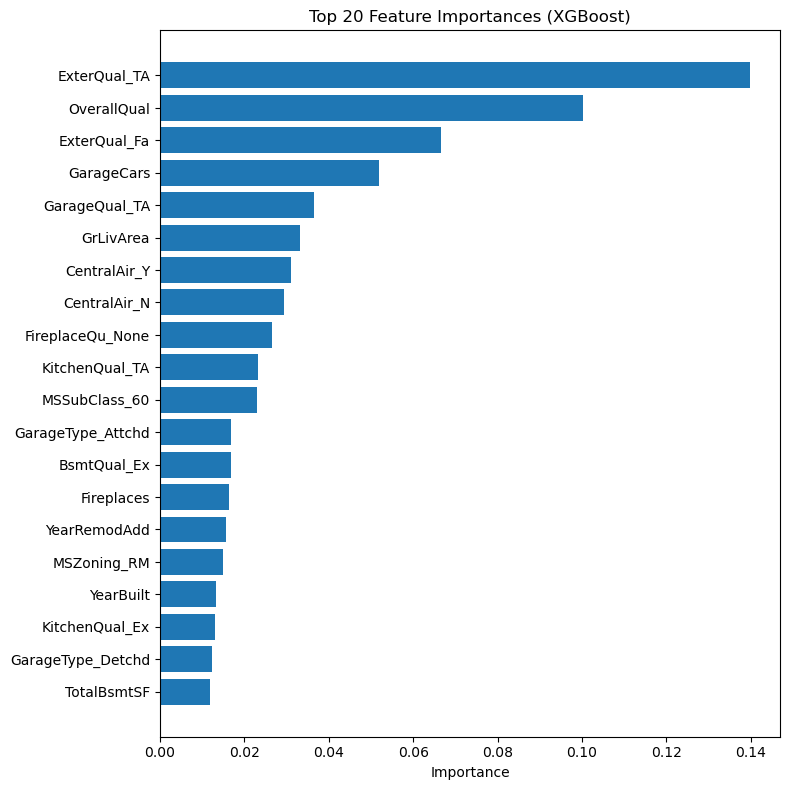

In [14]:
# Plot top 20 features
top_k = 20
top_features = fi_df.head(top_k).sort_values("importance", ascending=True)

plt.figure(figsize=(8, 8))
plt.barh(top_features["feature"], top_features["importance"])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


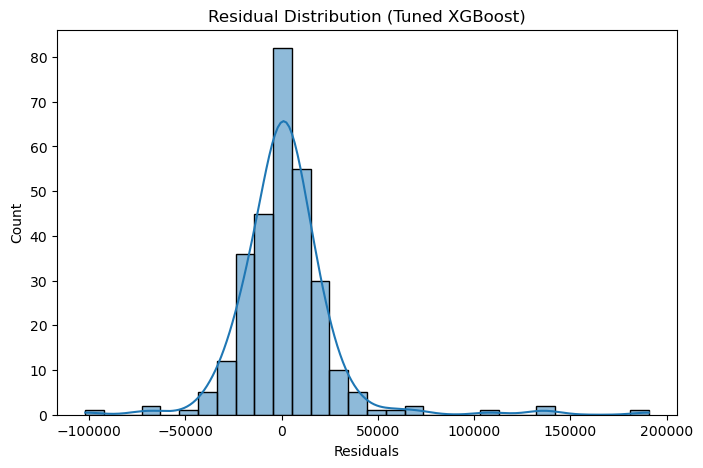

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

residuals = y_val_true - y_val_pred_best

plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.title("Residual Distribution (Tuned XGBoost)")
plt.show()


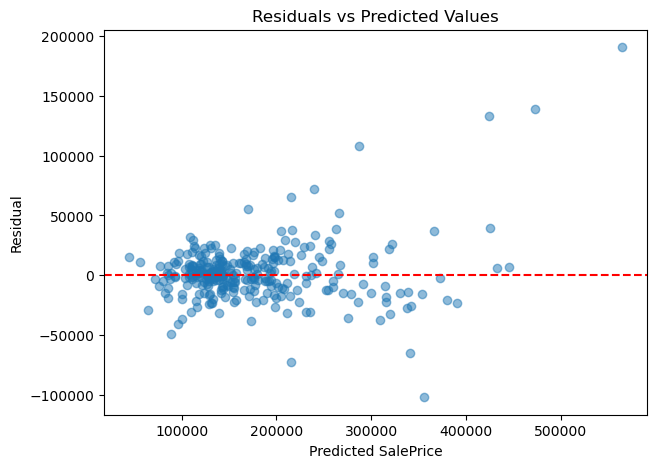

In [16]:
plt.figure(figsize=(7,5))
plt.scatter(y_val_pred_best, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted Values")
plt.show()


In [ ]:
# ============================================
# FINAL XGBOOST METRICS ON VALIDATION SET
# ============================================

# Re-transform validation set
X_val_trans_full = preprocessor.transform(X_val)

# Predict (log scale)
y_val_pred_log_xgb = best_model.named_steps["model"].predict(X_val_trans_full)

# Convert to SalePrice scale
y_val_true_xgb = np.expm1(y_val.values)
y_val_pred_xgb = np.expm1(y_val_pred_log_xgb)

# Compute metrics
mse_xgb  = mean_squared_error(y_val_true_xgb, y_val_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb  = mean_absolute_error(y_val_true_xgb, y_val_pred_xgb)
r2_xgb   = r2_score(y_val_true_xgb, y_val_pred_xgb)

print("===================================")
print(" FINAL XGBOOST PERFORMANCE ")
print("===================================")
print(f"MSE  : {mse_xgb:,.4f}")
print(f"RMSE : {rmse_xgb:,.4f}")
print(f"MAE  : {mae_xgb:,.4f}")
print(f"R²   : {r2_xgb:,.4f}")


 FINAL XGBOOST PERFORMANCE 
MSE  : 647,726,550.4016
RMSE : 25,450.4725
MAE  : 15,303.7658
R²   : 0.9156


Exception ignored in: <function ResourceTracker.__del__ at 0x102fcf2e0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1040632e0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__